In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 31 14:33:57 2023

@author: Lin
"""

import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import sys
sys.path.append(current_path+'/../../')
import myInput
import post_processing as inclination_processing
import PACKAGE_MP_3DLinear as linear3d

## Functions

In [2]:

def euler2quaternion(yaw, pitch, roll):
    """Convert euler angle into quaternion"""

    qx = np.cos(pitch/2.)*np.cos((yaw+roll)/2.)
    qy = np.sin(pitch/2.)*np.cos((yaw-roll)/2.)
    qz = np.sin(pitch/2.)*np.sin((yaw-roll)/2.)
    qw = np.cos(pitch/2.)*np.sin((yaw+roll)/2.)

    return [qx, qy, qz, qw]


def symquat(index, Osym = 24):
    """Convert one(index) symmetric matrix into a quaternion """

    q = np.zeros(4)

    if Osym == 24:
        SYM = np.array([[1, 0, 0,  0, 1, 0,  0, 0, 1],
                        [1, 0, 0,  0, -1, 0,  0, 0, -1],
                        [1, 0, 0,  0, 0, -1,  0, 1, 0],
                        [1, 0, 0,  0, 0, 1,  0, -1, 0],
                        [-1, 0, 0,  0, 1, 0,  0, 0, -1],
                        [-1, 0, 0,  0, -1, 0,  0, 0, 1],
                        [-1, 0, 0,  0, 0, -1,  0, -1, 0],
                        [-1, 0, 0,  0, 0, 1,  0, 1, 0],
                        [0, 1, 0, -1, 0, 0,  0, 0, 1],
                        [0, 1, 0,  0, 0, -1, -1, 0, 0],
                        [0, 1, 0,  1, 0, 0,  0, 0, -1],
                        [0, 1, 0,  0, 0, 1,  1, 0, 0],
                        [0, -1, 0,  1, 0, 0,  0, 0, 1],
                        [0, -1, 0,  0, 0, -1,  1, 0, 0],
                        [0, -1, 0, -1, 0, 0,  0, 0, -1],
                        [0, -1, 0,  0, 0, 1, -1, 0, 0],
                        [0, 0, 1,  0, 1, 0, -1, 0, 0],
                        [0, 0, 1,  1, 0, 0,  0, 1, 0],
                        [0, 0, 1,  0, -1, 0,  1, 0, 0],
                        [0, 0, 1, -1, 0, 0,  0, -1, 0],
                        [0, 0, -1,  0, 1, 0,  1, 0, 0],
                        [0, 0, -1, -1, 0, 0,  0, 1, 0],
                        [0, 0, -1,  0, -1, 0, -1, 0, 0],
                        [0, 0, -1,  1, 0, 0,  0, -1, 0]])
    elif Osym == 12:
        a = np.sqrt(3)/2
        SYM = np.array([[1,  0, 0,  0,   1, 0,  0, 0,  1],
                        [-0.5,  a, 0, -a, -0.5, 0,  0, 0,  1],
                        [-0.5, -a, 0,  a, -0.5, 0,  0, 0,  1],
                        [0.5,  a, 0, -a, 0.5, 0,  0, 0,  1],
                        [-1,  0, 0,  0,  -1, 0,  0, 0,  1],
                        [0.5, -a, 0,  a, 0.5, 0,  0, 0,  1],
                        [-0.5, -a, 0, -a, 0.5, 0,  0, 0, -1],
                        [1,  0, 0,  0,  -1, 0,  0, 0, -1],
                        [-0.5,  a, 0,  a, 0.5, 0,  0, 0, -1],
                        [0.5,  a, 0,  a, -0.5, 0,  0, 0, -1],
                        [-1,  0, 0,  0,   1, 0,  0, 0, -1],
                        [0.5, -a, 0, -a, -0.5, 0,  0, 0, -1]])

    if (1+SYM[index, 0]+SYM[index, 4]+SYM[index, 8]) > 0:
        q4 = np.sqrt(1+SYM[index, 0]+SYM[index, 4]+SYM[index, 8])/2
        q[0] = q4
        q[1] = (SYM[index, 7]-SYM[index, 5])/(4*q4)
        q[2] = (SYM[index, 2]-SYM[index, 6])/(4*q4)
        q[3] = (SYM[index, 3]-SYM[index, 1])/(4*q4)
    elif (1+SYM[index, 0]-SYM[index, 4]-SYM[index, 8]) > 0:
        q4 = np.sqrt(1+SYM[index, 0]-SYM[index, 4]-SYM[index, 8])/2
        q[0] = (SYM[index, 7]-SYM[index, 5])/(4*q4)
        q[1] = q4
        q[2] = (SYM[index, 3]+SYM[index, 1])/(4*q4)
        q[3] = (SYM[index, 2]+SYM[index, 6])/(4*q4)
    elif (1-SYM[index, 0]+SYM[index, 4]-SYM[index, 8]) > 0:
        q4 = np.sqrt(1-SYM[index, 0]+SYM[index, 4]-SYM[index, 8])/2
        q[0] = (SYM[index, 2]-SYM[index, 6])/(4*q4)
        q[1] = (SYM[index, 3]+SYM[index, 1])/(4*q4)
        q[2] = q4
        q[3] = (SYM[index, 7]+SYM[index, 5])/(4*q4)
    elif (1-SYM[index, 0]-SYM[index, 4]+SYM[index, 8]) > 0:
        q4 = np.sqrt(1-SYM[index, 0]-SYM[index, 4]+SYM[index, 8])/2
        q[0] = (SYM[index, 3]-SYM[index, 1])/(4*q4)
        q[1] = (SYM[index, 2]+SYM[index, 6])/(4*q4)
        q[2] = (SYM[index, 7]+SYM[index, 5])/(4*q4)
        q[3] = q4

    return q


def quat_Multi(q1, q2):
    """Return the product of two quaternion"""

    q = np.zeros(4)
    q[0] = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
    q[1] = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
    q[2] = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
    q[3] = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]

    return q

def in_cubic_fz(m_axis):
    # check if the misoreintation axis in fundamental zone
    # three core axis
    axis_a = np.array([1,0,0])
    axis_b = np.array([1,1,0])/np.sqrt(2)
    axis_c = np.array([1,1,1])/np.sqrt(3)
    # if in fz
    judgement_0 = np.dot(np.cross(axis_a, axis_b), m_axis) >= 0
    judgement_1 = np.dot(np.cross(axis_b, axis_c), m_axis) >= 0
    judgement_2 = np.dot(np.cross(axis_c, axis_a), m_axis) >= 0
    # print(f"{judgement_0}, {judgement_1}, {judgement_2}")
    return judgement_0*judgement_1*judgement_2


def quaternions_fz(q1, q2, symm2quat_matrix, Osym=24):
    """Return the misorientation of two quaternion"""

    q = np.zeros(4)
    misom = 2*np.pi
    axis = np.array([1, 0, 0])
    # print(f"q1: {q1}, q2: {q2}")
    for i in range(0, Osym):
        for j in range(0, Osym):
            # get misorientation quaternion q
            q1b = quat_Multi(symm2quat_matrix[i], q1)
            q2b = quat_Multi(symm2quat_matrix[j], q2)
            q2b[1:] = -q2b[1:]
            q = quat_Multi(q1b, q2b)
            # print(q)
            # get the q and inverse of q
            q_and_inverse = np.array([q,q])
            q_and_inverse[1,1:] = -q_and_inverse[1,1:]
            # get m_axis and inverse m_axis
            base = np.sqrt(1-q[0]*q[0])
            if base: axis_tmp = q_and_inverse[:,1:]/base
            else: axis_tmp = np.array([[1, 0, 0],[1, 0, 0]])
            # judge if the m_axis in fundamental zone or not
            in_cubic_fz_result = in_cubic_fz(axis_tmp.T)
            if not np.sum(in_cubic_fz_result): continue
            
            # find the index of m_axis in fundamental zone or not
            true_index = np.squeeze(np.where(in_cubic_fz_result))
            # find the minimal miso angle
            miso0 = 2*math.acos(round(q[0], 5))
            if miso0 > np.pi: miso0 = miso0 - 2*np.pi
            if abs(miso0) < misom:
                misom = abs(miso0)
                qmin = q_and_inverse[true_index]
                axis = axis_tmp[true_index]

    return misom, axis


def multiP_calM(i, quartAngle, symm2quat_matrix, Osym):
    """output the value of MisoEnergy by inout the two grain ID: i[0] and i[1]"""

    qi = quartAngle[i[0]-1, :]
    qj = quartAngle[i[1]-1, :]

    theta, axis = quaternions_fz(qi, qj, symm2quat_matrix, Osym)
    # theta = theta*(theta<1)+(theta>1)
    # gamma = theta*(1-np.log(theta))
    gamma = theta
    return np.insert(axis, 0, gamma)

def pre_operation_misorientation(grainNum, init_filename, Osym=24):
    # create the marix to store euler angle and misorientation
    quartAngle = np.ones((grainNum, 4))*-2

    # Create a quaternion matrix to show symmetry
    symm2quat_matrix = np.zeros((Osym, 4))
    for i in range(0, Osym):
        symm2quat_matrix[i, :] = symquat(i, Osym)

    # read the input euler angle from *.init
    with open(init_filename, 'r', encoding='utf-8') as f:
        for line in f:
            eachline = line.split()

            if len(eachline) == 5 and eachline[0] != '#':
                lineN = int(eachline[1])-1
                if quartAngle[lineN, 0] == -2:
                    quartAngle[lineN, :] = euler2quaternion(float(eachline[2]), float(eachline[3]), float(eachline[4]))

    return symm2quat_matrix, quartAngle

def get_line(i, j):
    """Get the row order of grain i and grain j in MisoEnergy.txt (i < j)"""
    if i < j: return int(i+(j-1)*(j)/2)
    else: return int(j+(i-1)*(i)/2)

def get_misorientation_distribution_1D(microstructure, quartAngle, symm2quat_matrix, Osym, num_bin, miso_dict):
    misorientation_angle_distribution = np.zeros(num_bin)
    nx,ny,nz = microstructure.shape
    for i in tqdm(range(nx)):
        for j in range(ny):
            for k in range(nz):
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(nx,ny,nz,i,j,k)
                if ( ((microstructure[ip,j,k]-microstructure[i,j,k])!=0) or ((microstructure[im,j,k]-microstructure[i,j,k])!=0) or\
                     ((microstructure[i,jp,k]-microstructure[i,j,k])!=0) or ((microstructure[i,jm,k]-microstructure[i,j,k])!=0) or\
                     ((microstructure[i,j,kp]-microstructure[i,j,k])!=0) or ((microstructure[i,j,km]-microstructure[i,j,k])!=0) ):
                    central_site = int(microstructure[i,j,k])
                    neighboring_sites_list = np.array([microstructure[ip,j,k], microstructure[i,jp,k], microstructure[i,j,kp], microstructure[im,j,k], microstructure[i,jm,k], microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    # print(f"center: {central_site}, neighbor: {neighboring_sites_set}")
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    for m in range(len(neighboring_sites_list_unque)):
                        pair_id = get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                        # calculate or extract misorientation
                        if pair_id in miso_dict:
                            misorientation_angle = miso_dict[pair_id][0]
                        else:
                            misorientation = multiP_calM([central_site, neighboring_sites_list_unque[m]], quartAngle, symm2quat_matrix, Osym)
                            misorientation_angle = misorientation[0] # miso angle
                            miso_dict[pair_id] = misorientation

                        # Get misorientation angle distribution
                        if misorientation_angle < 0 or misorientation_angle > np.pi: print(">>> Please check the miaorientation angle calculation!") # check angle error
                        misorientation_index = int(misorientation_angle//(np.pi/num_bin)) # get angle index to check the angle distribution
                        if misorientation_index == num_bin: misorientation_angle_distribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
                        else: misorientation_angle_distribution[misorientation_index] += 1 # all bins
    print(f"> Misorientation dictionary (len:{len(miso_dict)}) and misorientation angle distribution done")

    return misorientation_angle_distribution

def get_misorientation_distribution_3D(microstructure, quartAngle, symm2quat_matrix, Osym, num_bin, miso_dict, axis_num_bin):
    misorientation_angle_distribution = np.zeros(num_bin)
    misorientation_axis_polar_angle_dsitribution = np.zeros(axis_num_bin)
    misorientation_axis_azimuth_angle_dsitribution = np.zeros(axis_num_bin)
    misorientation_axis_matrix = np.zeros((axis_num_bin,axis_num_bin))
    m_angle_bin = 6
    m_angle_max = 65/180*np.pi
    misorientation_axis_matrix3D = np.zeros((axis_num_bin,axis_num_bin,m_angle_bin))
    misorientation_axis_energy_dsitribution = np.zeros(axis_num_bin)
    misorientation_axis_collective = []
    nx,ny,nz = microstructure.shape
    for i in tqdm(range(nx)):
        for j in range(ny):
            for k in range(nz):
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(nx,ny,nz,i,j,k)
                if ( ((microstructure[ip,j,k]-microstructure[i,j,k])!=0) or ((microstructure[im,j,k]-microstructure[i,j,k])!=0) or\
                     ((microstructure[i,jp,k]-microstructure[i,j,k])!=0) or ((microstructure[i,jm,k]-microstructure[i,j,k])!=0) or\
                     ((microstructure[i,j,kp]-microstructure[i,j,k])!=0) or ((microstructure[i,j,km]-microstructure[i,j,k])!=0) ):
                    central_site = int(microstructure[i,j,k])
                    neighboring_sites_list = np.array([microstructure[ip,j,k], microstructure[i,jp,k], microstructure[i,j,kp], microstructure[im,j,k], microstructure[i,jm,k], microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    # print(f"center: {central_site}, neighbor: {neighboring_sites_set}")
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    for m in range(len(neighboring_sites_list_unque)):
                        pair_id = get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                        # calculate or extract misorientation
                        if pair_id in miso_dict:
                            misorientation_angle = miso_dict[pair_id][0]
                            misorientation_axis = miso_dict[pair_id][1:]
                        else:
                            misorientation = multiP_calM([central_site, neighboring_sites_list_unque[m]], quartAngle, symm2quat_matrix, Osym)
                            misorientation_angle = misorientation[0] # miso angle
                            misorientation_axis = misorientation[1:]
                            miso_dict[pair_id] = misorientation

                        # Get misorientation angle distribution
                        if misorientation_angle < 0 or misorientation_angle > np.pi: print(">>> Please check the misorientation angle calculation!") # check angle error
                        misorientation_index = int(misorientation_angle//(np.pi/num_bin)) # get angle index to check the angle distribution
                        if misorientation_index == num_bin: misorientation_angle_distribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
                        else: misorientation_angle_distribution[misorientation_index] += 1 # all bins
                        # Get misorientation axis collective
                        misorientation_axis_collective.append(misorientation_axis)
                        # Get polar and azimuth dsitribution
                        m_polar_angle = math.acos(round(misorientation_axis[2],3))
                        m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
                        if m_polar_angle < 0 or m_polar_angle > np.pi or m_azimuth_angle < 0 or m_azimuth_angle > 2*np.pi: print(">>> Please check the misorientation axis calculation!") # check angle error
                        m_polar_angle_index = int(m_polar_angle//(np.pi/axis_num_bin)) # get angle index to check the angle distribution
                        m_azimuth_angle_index = int(m_azimuth_angle//(2*np.pi/axis_num_bin)) # get angle index to check the angle distribution
                        if m_polar_angle_index == axis_num_bin: misorientation_axis_polar_angle_dsitribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
                        else: misorientation_axis_polar_angle_dsitribution[m_polar_angle_index] += 1 # all bins
                        if m_azimuth_angle_index == axis_num_bin: misorientation_axis_azimuth_angle_dsitribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
                        else: misorientation_axis_azimuth_angle_dsitribution[m_azimuth_angle_index] += 1 # all bins
                        misorientation_index_matrix = int(misorientation_angle//(m_angle_max/m_angle_bin))
                        # Get polar and azimuth dsitribution in matrix
                        x_index = m_polar_angle_index
                        y_index = m_azimuth_angle_index
                        z_index = misorientation_index_matrix
                        if m_polar_angle_index == axis_num_bin: x_index = x_index - 1
                        if m_azimuth_angle_index == axis_num_bin: y_index = y_index - 1
                        if misorientation_index_matrix == m_angle_bin: z_index = z_index - 1
                        misorientation_axis_matrix[x_index, y_index] += 1
                        misorientation_axis_matrix3D[x_index, y_index, z_index] += 1
                        # Get energy dsitribution
                        energy_index = int(energy_function_m_axis_new(m_polar_angle, m_azimuth_angle)//(1/axis_num_bin))
                        misorientation_axis_energy_dsitribution[energy_index] += 1



    print(f"> Misorientation dictionary (len:{len(miso_dict)}) and misorientation angle distribution done")
    misorientation_axis_collective = np.array(misorientation_axis_collective) # a coolective iincludes all misorientation axis

    # normalize
    misorientation_angle_distribution = misorientation_angle_distribution / np.sum(misorientation_angle_distribution*(np.pi/num_bin))
    misorientation_axis_polar_angle_dsitribution = misorientation_axis_polar_angle_dsitribution / np.sum(misorientation_axis_polar_angle_dsitribution*(np.pi/axis_num_bin))
    misorientation_axis_azimuth_angle_dsitribution = misorientation_axis_azimuth_angle_dsitribution / np.sum(misorientation_axis_azimuth_angle_dsitribution*(2*np.pi/axis_num_bin))

    # misorientation_axis_matrix = misorientation_axis_matrix / np.sum(misorientation_axis_matrix*(np.pi/axis_num_bin*2*np.pi/axis_num_bin))
    misorientation_axis_matrix3D = misorientation_axis_matrix3D / np.sum(misorientation_axis_matrix3D*(np.pi/axis_num_bin*2*np.pi/axis_num_bin*m_angle_max/m_angle_bin))
    misorientation_axis_energy_dsitribution = misorientation_axis_energy_dsitribution / np.sum(misorientation_axis_energy_dsitribution*(1/axis_num_bin))

    return misorientation_angle_distribution, misorientation_axis_collective, misorientation_axis_polar_angle_dsitribution, misorientation_axis_azimuth_angle_dsitribution, misorientation_axis_matrix, misorientation_axis_energy_dsitribution, misorientation_axis_matrix3D

def calculate_expected_step(input_list, expected_grain_num=200):

    num_input = len(input_list)
    special_step_distribution = np.zeros(num_input)
    microstructure_list = []

    for input_i in range(num_input):
        npy_data = np.load(input_list[input_i])
        step_num = npy_data.shape[0]
        grain_num_list = np.zeros(step_num)
        for i in tqdm(range(step_num)):
            grain_num_list[i] = len(set(npy_data[i,:].flatten()))
        special_step_distribution[input_i] = int(np.argmin(abs(grain_num_list - expected_grain_num)))
        microstructure_list.append(npy_data[int(special_step_distribution[input_i]),:])
    print("> Step calculation done")

    return special_step_distribution, microstructure_list

def get_inclination_angle_distribution_1D(P, sites, miso_dict, num_bin):

    microstructure = P[0,:]
    inclination_angle_distribution = np.zeros(num_bin)
    for sitei in tqdm(sites):
        [i,j,k] = sitei
        # Get the site pair to caluclate misorientation
        nx, ny, nz = microstructure.shape
        ip,im,jp,jm,kp,km = myInput.periodic_bc3d(nx,ny,nz,i,j,k)
        central_site = int(microstructure[i,j,k])
        neighboring_sites_list = np.array([microstructure[ip,j,k], microstructure[i,jp,k], microstructure[i,j,kp], microstructure[im,j,k], microstructure[i,jm,k], microstructure[i,j,km]]).astype(int)
        neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
        if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
        neighboring_sites_list_unque = list(neighboring_sites_set)
        if len(neighboring_sites_list_unque) > 1: continue # ignore the site on TJs
        pair_id = get_line(central_site, neighboring_sites_list_unque[0]) # get pair id

        # Get misorientation axis
        # print(pair_id)
        misorientation = miso_dict[pair_id] # get the misorientation of specific site
        misorientation_axis = misorientation[1:] # get misorientation axis

        # Get inclination
        dx,dy,dz = myInput.get_grad3d(P,i,j,k)
        dy = -dy # Update the issue in VECTOR
        inclination = np.array([dx,dy,dz])

        # Make sure inclination angle is between [0, pi/2]
        inclination_cos_angle = round(np.sum(misorientation_axis*inclination), 2)
        inclination_angle = math.acos(abs(inclination_cos_angle))
        if inclination_angle > np.pi/2: inclination_angle = np.pi - inclination_angle

        inclination_index = int(inclination_angle//(np.pi/num_bin)) # get angle index to check the angle distribution
        if inclination_index == num_bin: inclination_angle_distribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
        else: inclination_angle_distribution[inclination_index] += 1 # all bins

    return inclination_angle_distribution

def get_inclination_angle_distribution_2D(P, sites, miso_dict, num_bin):

    microstructure = P[0,:]
    inclination_collective = []
    inclination_polar_angle_distribution = np.zeros(num_bin)
    inclination_azimuth_angle_distribution = np.zeros(num_bin)
    inclination_axis_matrix = np.zeros((num_bin,num_bin))
    inclination_energy_distribution = np.zeros(num_bin)
    for sitei in tqdm(sites):
        [i,j,k] = sitei
        # Get the site pair to caluclate misorientation
        nx, ny, nz = microstructure.shape
        ip,im,jp,jm,kp,km = myInput.periodic_bc3d(nx,ny,nz,i,j,k)
        central_site = int(microstructure[i,j,k])
        neighboring_sites_list = np.array([microstructure[ip,j,k], microstructure[i,jp,k], microstructure[i,j,kp], microstructure[im,j,k], microstructure[i,jm,k], microstructure[i,j,km]]).astype(int)
        neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
        if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
        neighboring_sites_list_unque = list(neighboring_sites_set)
        if len(neighboring_sites_list_unque) > 1: continue # ignore the site on TJs
        pair_id = get_line(central_site, neighboring_sites_list_unque[0]) # get pair id

        # Get misorientation axis
        # print(pair_id)
        misorientation = miso_dict[pair_id] # get the misorientation of specific site
        misorientation_axis = misorientation[1:] # get misorientation axis

        # Get inclination
        dx,dy,dz = myInput.get_grad3d(P,i,j,k)
        dy = -dy # Update the issue in VECTOR
        inclination = np.array([dx,dy,dz])

        # rotate misorientation axis to z axis, and incliantion to final vector
        z_axis = np.array([0,0,1])
        rotation_matrix_m_axis_to_z_axis = rotation_matrix_from_vectors(misorientation_axis, z_axis)
        incliantion_refer_m_axis = rotation_matrix_m_axis_to_z_axis.dot(inclination)
        inclination_collective.append(incliantion_refer_m_axis) # inclination collective

        # Get polar and azimuth dsitribution
        i_polar_angle = math.acos(round(incliantion_refer_m_axis[2],3))
        i_azimuth_angle = math.atan2(incliantion_refer_m_axis[1], incliantion_refer_m_axis[0]) + np.pi

        # Make sure inclination polar angle is between [0, pi/2] and calculate the distribution
        if i_polar_angle > np.pi/2: i_polar_angle = np.pi - i_polar_angle
        inclination_polar_angle_index = int(i_polar_angle//(np.pi/num_bin/2)) # get polar angle index to check the angle distribution
        if inclination_polar_angle_index == num_bin: inclination_polar_angle_distribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
        else: inclination_polar_angle_distribution[inclination_polar_angle_index] += 1 # all bins

        # Calculate the azimuth angle distribution
        if i_azimuth_angle < 0 or i_azimuth_angle > 2*np.pi: print("The inclinaiton azimuth angle is wrong, please double check.")
        inclination_azimuth_angle_index = int(i_azimuth_angle//(2*np.pi/num_bin)) # get azimuth angle index to check the angle distribution
        if inclination_azimuth_angle_index == num_bin: inclination_azimuth_angle_distribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
        else: inclination_azimuth_angle_distribution[inclination_azimuth_angle_index] += 1 # all bins

        # energy distribution
        x_index = inclination_polar_angle_index
        y_index = inclination_azimuth_angle_index
        if inclination_polar_angle_index == num_bin: x_index = x_index - 1
        if inclination_azimuth_angle_index == num_bin: y_index = y_index - 1
        inclination_axis_matrix[x_index, y_index] += 1 # energy matrix
        energy_index = int(energy_function_i_axis(x_index/num_bin*np.pi/2, y_index/num_bin*2*np.pi)//(1/num_bin))
        inclination_energy_distribution[energy_index] += 1

    # normalize
    inclination_polar_angle_distribution = inclination_polar_angle_distribution / np.sum(inclination_polar_angle_distribution*(np.pi/num_bin/2))
    inclination_azimuth_angle_distribution = inclination_azimuth_angle_distribution / np.sum(inclination_azimuth_angle_distribution*(2*np.pi/num_bin))

    inclination_axis_matrix = inclination_axis_matrix / np.sum(inclination_axis_matrix*(np.pi/num_bin/2*2*np.pi/num_bin))
    inclination_energy_distribution = inclination_energy_distribution / np.sum(inclination_energy_distribution*(1.0/num_bin))

    return inclination_polar_angle_distribution, inclination_azimuth_angle_distribution, inclination_axis_matrix, inclination_energy_distribution

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def energy_function_m_axis(m_polar_angle, m_azimuth_angle):
    return abs(np.cos(m_azimuth_angle)) * m_polar_angle / np.pi

def energy_function_m_axis_new(m_polar_angle, m_azimuth_angle):
    # ss = abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))
    # ss = (abs(np.cos(m_azimuth_angle/2))**0.4 + abs(np.cos(m_polar_angle))**0.4)
    ss = (abs(np.cos(m_azimuth_angle/2))**0.4 + abs(np.cos(m_polar_angle))**0.4)
    if ss > 1: return 1
    else: return ss
    # return (abs(np.cos(m_azimuth_angle/2))**1.0 + abs(np.cos(m_polar_angle))**1.0)

def energy_function_m_angle(m_angle):
    max_m_angle = 65/180*np.pi
    if m_angle == 0: return 0
    if m_angle >= max_m_angle: return 1
    return m_angle/max_m_angle*(1-np.log(m_angle/max_m_angle))

def energy_function_m(m_polar_angle, m_azimuth_angle, m_angle):
    return energy_function_m_axis_new(m_polar_angle, m_azimuth_angle)*energy_function_m_angle(m_angle)

def energy_function_i_axis(i_polar_angle, i_azimuth_angle):
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7 + i_polar_angle / (np.pi/2) * (0.3 - 0.7))

print("Done")

Done


## initial

In [ ]:

if __name__ == '__main__':
    # File name
    case_name = "2400_20kMI"
    # case_name = "450_5k"
    init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    npy_file_folder_iso = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/results/"
    init_file_name = "Case4.init"
    npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_iso = f"p_ori_ave_aveE_20000_multiCore32_delta0.0_m2_J1_refer_1_0_0_seed56689_kt066.npy"
    input_npy_data = [npy_file_folder+npy_file_name_aniso, npy_file_folder_iso+npy_file_name_iso]
    compare_label = ["Anisotropic", "Isotropic"]

    # Get time step with expected grain num
    expected_grain_num = 1000
    special_step_distribution, microstructure_list = inclination_processing.calculate_expected_step(input_npy_data, expected_grain_num)
    print(f"Steps for {compare_label} are {list(map(int, special_step_distribution))}")
    

    # misorientation
    grain_num = 20000
    Osym = 24
    symm2quat_matrix, quartAngle = pre_operation_misorientation(grain_num, init_file_folder + init_file_name, Osym)
    num_bin = 100
    axis_num_bin = 200
    print("> Pre-work done")


  1%|          | 5/601 [00:01<02:15,  4.39it/s]

In [ ]:
# EA for 1/1/24 with 0.937 energy
# 901: 1.1285557 0.79227585 1.8645675
# 998: 1.5482855 0.19762605 4.1342216
# EA for 25/25/24 with 0.500 energy
# 14: 2.8323882, 1.4979148, 5.0947437
# 960: 0.32319507 0.85375726 1.9177127

# p1 = euler2quaternion(1.1285557, 0.79227585, 1.8645675)
# p2 = euler2quaternion(1.5482855, 0.19762605, 4.1342216)
# print(p1)
# print(p2)
# misorientation_angle, misorientation_axis = quaternions_fz(p1, p2, symm2quat_matrix, Osym)
# print(f"misorientation_angle: {misorientation_angle}, misorientation_axis: {misorientation_axis}")
# m_polar_angle = math.acos(round(misorientation_axis[2],3))
# m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
# misorientation_index = int(misorientation_angle//(np.pi/num_bin))
# m_polar_angle_index = int(m_polar_angle//(np.pi/axis_num_bin)) # get angle index to check the angle distribution
# m_azimuth_angle_index = int(m_azimuth_angle//(2*np.pi/axis_num_bin)) # get angle index to check the angle distribution
# print(f"m_polar_angle_index: {m_polar_angle_index}/{axis_num_bin}")
# print(f"m_azimuth_angle_index: {m_azimuth_angle_index}/{axis_num_bin}")
# print(f"misorientation_index: {misorientation_index}/{num_bin}")
# print(f"energy: {0.3+0.7*energy_function_m(m_polar_angle, m_azimuth_angle, misorientation_angle)}")
# print()

# from scipy.spatial.transform import Rotation as R
# # Quaternion [q0, q1, q2, q3]
# # quaternion = [ 0.81950762, 0.39621348, 0.28927163, -0.29621623]
# quaternion = [ 0.5, 0.5, 0.5, 0.5]
# # Convert to Euler Angles (Bunge ZXZ)
# rotation = R.from_quat(quaternion)
# euler_angles = rotation.as_euler('ZXZ', degrees=False)
# print("Euler Angles (ZXZ):", euler_angles)
# print(euler2quaternion(euler_angles[0],euler_angles[1],euler_angles[2]))

## misorientation calculation

In [ ]:
    # Get misorientation angle distribution and dictionary
    misorientation_angle_distribution_list = []
    misorientation_axis_collective_list = []
    misorientation_axis_polar_angle_distribution_list = []
    misorientation_axis_azimuth_angle_distribution_list = []
    misorientation_axis_matrix_list = []
    misorientation_axis_energy_distribution_list = []
    misorientation_axis_matrix3D_list = []
    miso_dict = dict()
    for i in range(len(input_npy_data)):
        microstructure = microstructure_list[i]
        misorientation_angle_distribution, misorientation_axis_collective, misorientation_axis_polar_angle_distribution, misorientation_axis_azimuth_angle_distribution, misorientation_axis_matrix, misorientation_axis_energy_dsitribution, misorientation_axis_matrix3D = get_misorientation_distribution_3D(microstructure, quartAngle, symm2quat_matrix, Osym, num_bin, miso_dict, axis_num_bin)
        misorientation_angle_distribution_list.append(misorientation_angle_distribution)
        misorientation_axis_collective_list.append(misorientation_axis_collective)
        misorientation_axis_polar_angle_distribution_list.append(misorientation_axis_polar_angle_distribution)
        misorientation_axis_azimuth_angle_distribution_list.append(misorientation_axis_azimuth_angle_distribution)
        misorientation_axis_matrix_list.append(misorientation_axis_matrix)
        misorientation_axis_energy_distribution_list.append(misorientation_axis_energy_dsitribution)
        misorientation_axis_matrix3D_list.append(misorientation_axis_matrix3D)
        print(f"> {compare_label[i]} done")
        
    
        
        

In [10]:
#     for i in range(len(special_step_distribution_add)):
#         microstructure = microstructure_array_add[i]
#         misorientation_angle_distribution, misorientation_axis_collective, misorientation_axis_polar_angle_distribution, misorientation_axis_azimuth_angle_distribution, misorientation_axis_matrix, misorientation_axis_energy_dsitribution, misorientation_axis_matrix3D = get_misorientation_distribution_3D(microstructure, quartAngle, symm2quat_matrix, Osym, num_bin, miso_dict, axis_num_bin)
#         misorientation_angle_distribution_list[0] += misorientation_angle_distribution
#         misorientation_axis_polar_angle_distribution_list[0] += misorientation_axis_polar_angle_distribution
#         misorientation_axis_azimuth_angle_distribution_list[0] += misorientation_axis_azimuth_angle_distribution
#         misorientation_axis_matrix_list[0] += misorientation_axis_matrix
#         misorientation_axis_energy_distribution_list[0] += misorientation_axis_energy_dsitribution
#     misorientation_angle_distribution_list[0] = misorientation_angle_distribution_list[0]/np.sum(misorientation_angle_distribution_list[0]*(np.pi/num_bin))
#     misorientation_axis_polar_angle_distribution_list[0] = misorientation_axis_polar_angle_distribution_list[0] / np.sum(misorientation_axis_polar_angle_distribution_list[0]*(np.pi/axis_num_bin))
#     misorientation_axis_azimuth_angle_distribution_list[0] = misorientation_axis_azimuth_angle_distribution_list[0] / np.sum(misorientation_axis_azimuth_angle_distribution_list[0]*(2*np.pi/axis_num_bin))
#     misorientation_axis_matrix_list[0] = misorientation_axis_matrix_list[0] / np.sum(misorientation_axis_matrix_list[0]*(np.pi/axis_num_bin*2*np.pi/axis_num_bin))
#     misorientation_axis_energy_distribution_list[0] = misorientation_axis_energy_distribution_list[0] / np.sum(misorientation_axis_energy_distribution_list[0]*(1/axis_num_bin))

# misorientation_axis_matrix_add_list = []
# for i in range(len(special_step_distribution_add)):
#     microstructure = microstructure_array_add[i]
#     misorientation_angle_distribution, misorientation_axis_collective, misorientation_axis_polar_angle_distribution, misorientation_axis_azimuth_angle_distribution, misorientation_axis_matrix, misorientation_axis_energy_dsitribution, misorientation_axis_matrix3D = get_misorientation_distribution_3D(microstructure, quartAngle, symm2quat_matrix, Osym, num_bin, miso_dict, axis_num_bin)
# misorientation_axis_matrix_add_list.append(misorientation_axis_matrix)


## plot

In [ ]:
    # plot misorientation angle distribution
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    num_bin_plot = int(0.4*num_bin)
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,180,num_bin)[:num_bin_plot], misorientation_angle_distribution_list[i][:num_bin_plot], label=compare_label[i], linewidth=2)
    plt.legend(fontsize=14)
    # plt.legend(loc=(-0.04,-0.25),fontsize=16,ncol=2)
    plt.xlabel(r"Misorientation Angle ($^\circ$)", fontsize=16)
    plt.ylabel("Frequency (-)", fontsize=16)
    # plt.title("misorientation angle distribution")
    plt.savefig(current_path + f"/figures/{case_name}_misorientation_angle_distribution_3dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

    # plot misorientation axis distribution
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    num_bin_plot = int(axis_num_bin)
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,180,axis_num_bin)[:axis_num_bin], misorientation_axis_polar_angle_distribution_list[i][:axis_num_bin], label=compare_label[i], linewidth=2)
    plt.legend(loc=(-0.04,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.title("misorientation axis polar distribution")
    # plt.savefig(current_path + f"/figures/{case_name}_misorientation_axis_polar_distribution_3dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,360,axis_num_bin)[:axis_num_bin], misorientation_axis_azimuth_angle_distribution_list[i][:axis_num_bin], label=compare_label[i], linewidth=2)
    plt.legend(loc=(-0.04,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.title("misorientation axis azimuth distribution")
    # plt.savefig(current_path + f"/figures/{case_name}_misorientation_axis_azimuth_distribution_3dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

    # plot energy function
    # angle
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    m_angle_array = np.linspace(0,65/180*np.pi,100)
    energy_m_angle_array = np.zeros(len(m_angle_array))
    for input_i in range(len(m_angle_array)):
        energy_m_angle_array[input_i] = energy_function_m_angle(m_angle_array[input_i])
    plt.plot(m_angle_array,energy_m_angle_array,linewidth=2)
    plt.xlabel(r"Misorientation Angle ($^\circ$)", fontsize=18)
    plt.ylabel(r"Energy Factor (-)", fontsize=18)
    plt.xticks([0,65/180*np.pi], ['0',r'$\theta_{max}$'], fontsize=16)
    # plt.yticks(np.linspace(0,axis_num_bin,3), ['0',r'$\pi/2$',r'$\pi$'])
    plt.xlim([0,65/180*np.pi])
    plt.ylim([0,1])
    # plt.title("misorientation angle energy function")
    # plt.axis("off")
    plt.savefig(current_path + f"/figures/{case_name}_misorientation_angle_energy_3dofs.png", dpi=400,bbox_inches='tight')
    # axis
    # 100, 110, 111
    axis_100 = [axis_num_bin/2, int(0.5*np.pi//(np.pi/axis_num_bin))]
    axis_110 = [axis_num_bin/2+int(0.25*np.pi//(2*np.pi/axis_num_bin)), int(0.5*np.pi//(np.pi/axis_num_bin))]
    axis_111 = [axis_num_bin/2+int(0.25*np.pi//(2*np.pi/axis_num_bin)),int(0.9553//(np.pi/axis_num_bin))]
    m_axis_energy_function = np.zeros((axis_num_bin, axis_num_bin))
    for input_i in range(axis_num_bin):
        for input_j in range(axis_num_bin):
            m_axis_energy_function[input_i, input_j] = energy_function_m_axis_new(input_i/axis_num_bin*np.pi, input_j/axis_num_bin*2*np.pi)
    plt.figure()
    fig = plt.figure(figsize=(7, 5))
    min_tri = np.min(m_axis_energy_function[int(axis_num_bin/2):int(axis_num_bin/8+axis_num_bin/2), int(0.9553//(np.pi/axis_num_bin)):int(axis_num_bin/2)])
    max_tri = np.max(m_axis_energy_function[int(axis_num_bin/2):int(axis_num_bin/8+axis_num_bin/2), int(0.9553//(np.pi/axis_num_bin)):int(axis_num_bin/2)])
    plt.imshow(m_axis_energy_function,cmap='viridis_r',vmin=min_tri,vmax = max_tri)
    plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
    plt.ylabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
    plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
    plt.yticks(np.linspace(0,axis_num_bin,3), ['0',r'$\pi/2$',r'$\pi$'])
    plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2])
    plt.ylim([axis_num_bin/2,int(0.9553//(np.pi/axis_num_bin)-1)])
    plt.colorbar()
    # plt.title("misorientation axis energy function")
    plt.scatter(axis_100[0],axis_100[1],c='k',s=12)
    plt.text(axis_100[0]-2, axis_100[1]+2, "[100]", fontsize=16)
    plt.scatter(axis_110[0],axis_110[1],c='k',s=12)
    plt.text(axis_110[0]-2, axis_110[1]+2, "[110]", fontsize=16)
    plt.scatter(axis_111[0],axis_111[1],c='k',s=12)
    plt.text(axis_111[0]-2, axis_111[1]-0.7, "[111]", fontsize=16)
    plt.axis("off")
    plt.savefig(current_path + f"/figures/{case_name}_misorientation_axis_energy_3dofs.png", dpi=400,bbox_inches='tight')

    # plot frequency VS energy
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,1,axis_num_bin)[:axis_num_bin], misorientation_axis_energy_distribution_list[i][:axis_num_bin],'-', label=compare_label[i], linewidth=2)
    plt.legend(loc=(-0.04,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Misorientation Axis Energy", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.title("misorientation axis energy distribution")
    # plt.savefig(current_path + f"/figures/{case_name}_misorientation_axis_energy_distribution_3dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

    # Difference
    # plot matrix figure for misorientation axis distribution
    # plt.figure()
    # fig = plt.figure(figsize=(14, 5))
    # misorientation_axis_matrix_diff_list = []
    # mini_value = np.min((np.min(misorientation_axis_matrix_add_list[0] - misorientation_axis_matrix_list[0]), np.min(misorientation_axis_matrix_add_list[0] - misorientation_axis_matrix_list[1])))
    # plt.title(f"misorientation axis 2D distribution")
    # for i in range(len(input_npy_data)):
    #     tmp_miso = misorientation_axis_matrix_add_list[0] - misorientation_axis_matrix_list[i] - mini_value
    #     misorientation_axis_matrix_diff_list.append(tmp_miso / np.sum(tmp_miso*(np.pi/axis_num_bin*2*np.pi/axis_num_bin)))
    # for i in range(len(input_npy_data)):
    #     plt.subplot(1,2,int(i+1))
    #     plt.imshow(misorientation_axis_matrix_diff_list[i],cmap='viridis_r',vmin=0,vmax=np.max(misorientation_axis_matrix_diff_list))
    #     # print(compare_label[i])
    #     plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
    #     plt.ylabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
    #     plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
    #     plt.yticks(np.linspace(0,axis_num_bin,2), ['0',r'$\pi$'])
    #     plt.title(f"misorientation axis 2D distribution - {compare_label[i]}")
    #     plt.colorbar()
    
    # plot matrix figure for misorientation axis distribution
    plt.figure()
    fig = plt.figure(figsize=(14, 5))
    plt.title(f"misorientation axis distribution")
    X, Y = np.meshgrid(np.arange(axis_num_bin),np.arange(axis_num_bin))
    misorientation_axis_matrix_norm_list = []
    for i in range(len(input_npy_data)):
        misorientation_axis_matrix_norm_list.append(misorientation_axis_matrix_list[i]/np.sum(misorientation_axis_matrix_list[i]*(np.pi/axis_num_bin*2*np.pi/axis_num_bin)))
    for i in range(len(input_npy_data)):
        plt.subplot(1,2,int(i+1))
        plt.imshow(misorientation_axis_matrix_norm_list[i],cmap='viridis_r',vmin=0,vmax=np.max(misorientation_axis_matrix_norm_list))
        # plt.contourf(X, Y, misorientation_axis_matrix_norm_list[i], 5,cmap='viridis_r')
        plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
        plt.ylabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
        plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
        plt.yticks(np.linspace(0,axis_num_bin,3), ['0',r'$\pi/2$',r'$\pi$'])
        plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2])
        plt.ylim([axis_num_bin/2,int(0.9553//(np.pi/axis_num_bin)-1)])
        plt.title(f"misorientation axis 2D distribution - {compare_label[i]}")
        plt.axis("off")
        plt.colorbar()
        plt.scatter(axis_100[0],axis_100[1],c='k',s=12)
        plt.text(axis_100[0]-2, axis_100[1]+2, "[100]", fontsize=8)
        plt.scatter(axis_110[0],axis_110[1],c='k',s=12)
        plt.text(axis_110[0]-2, axis_110[1]+2, "[110]", fontsize=8)
        plt.scatter(axis_111[0],axis_111[1],c='k',s=12)
        plt.text(axis_111[0]-2, axis_111[1]-0.7, "[111]", fontsize=8)
        
    # plt.savefig(current_path + f"/figures/{case_name}_misorientation_axis_2D_distribution_3dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')
    # plot matrix difference for misorientation axis distribution
    max_anisotropy = np.max(abs(misorientation_axis_matrix_norm_list[0]-misorientation_axis_matrix_norm_list[1]))
    print(f"> The mex anisotropy for current {case_name} is {max_anisotropy}.")
    plt.figure()
    fig = plt.figure(figsize=(7, 5))
    plt.imshow(misorientation_axis_matrix_norm_list[0]-misorientation_axis_matrix_norm_list[1],cmap='coolwarm',
               vmin=-np.max(abs(misorientation_axis_matrix_norm_list[0]-misorientation_axis_matrix_norm_list[1])),
               vmax=np.max(abs(misorientation_axis_matrix_norm_list[0]-misorientation_axis_matrix_norm_list[1])),
               interpolation='bilinear')
    plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
    plt.ylabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
    plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
    plt.yticks(np.linspace(0,axis_num_bin,3), ['0',r'$\pi/2$',r'$\pi$'])
    plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2])
    plt.ylim([axis_num_bin/2,int(0.9553//(np.pi/axis_num_bin)-1)])
    # plt.title(f"misorientation axis 2D distribution difference (aniso-iso)")
    plt.colorbar()
    # plt.contour(X, Y, misorientation_axis_matrix_norm_list[0]-misorientation_axis_matrix_norm_list[1],10, colors='k')
    plt.scatter(axis_100[0],axis_100[1],c='k',s=12)
    plt.text(axis_100[0]-2, axis_100[1]+2, "[100]", fontsize=16)
    plt.scatter(axis_110[0],axis_110[1],c='k',s=12)
    plt.text(axis_110[0]-2, axis_110[1]+2, "[110]", fontsize=16)
    plt.scatter(axis_111[0],axis_111[1],c='k',s=12)
    plt.text(axis_111[0]-2, axis_111[1]-0.7, "[111]", fontsize=16)
    plt.axis("off")
    plt.savefig(current_path + f"/figures/{case_name}_misorientation_axis_2D_distribution_difference_3dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')
    


'264_5kMab'

<Figure size 432x288 with 0 Axes>

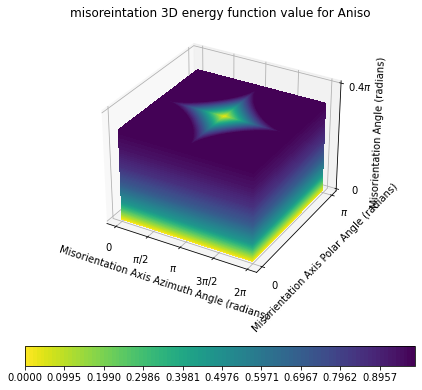

<Figure size 432x288 with 0 Axes>

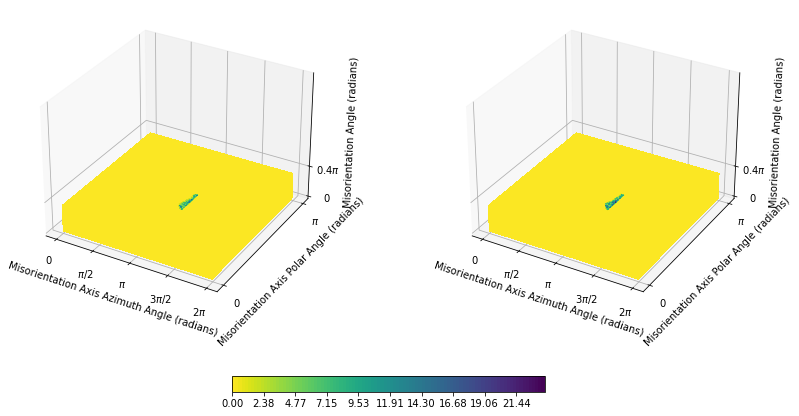

In [95]:

    # plot energy function
    m_angle_bin = 6
    m_axis_energy_function_3d = np.zeros((axis_num_bin, axis_num_bin, m_angle_bin))
    max_m_angle = 65/180*np.pi
    for input_i in range(axis_num_bin):
        for input_j in range(axis_num_bin):
            for input_k in range(m_angle_bin):
                m_axis_energy_function_3d[input_i, input_j, input_k] = energy_function_m(input_i/axis_num_bin*np.pi, input_j/axis_num_bin*2*np.pi, input_k/m_angle_bin*max_m_angle)
    X, Y, Z = np.meshgrid(np.arange(axis_num_bin),np.arange(axis_num_bin),np.arange(m_angle_bin))
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(projection='3d')
    kw = {
        'vmin': m_axis_energy_function_3d.min(),
        'vmax': m_axis_energy_function_3d.max(),
        'levels': np.linspace(m_axis_energy_function_3d.min(), m_axis_energy_function_3d.max(), 100),
        'cmap': 'viridis_r',
    }
    # Plot contour surfaces
    _ = ax.contourf(
        X[:, :, -1], Y[:, :, -1], m_axis_energy_function_3d[:, :, -1],
        zdir='z', offset=Z.max(), **kw
    )
    _ = ax.contourf(
        X[0, :, :], m_axis_energy_function_3d[0, :, :], Z[0, :, :],
        zdir='y', offset=0, **kw
    )
    C = ax.contourf(
        m_axis_energy_function_3d[:, -1, :], Y[:, -1, :], Z[:, -1, :],
        zdir='x', offset=X.max(), **kw
    )
    plt.colorbar(C, orientation = 'horizontal', shrink=1.0)
    plt.xlabel(r"Misorientation Axis Azimuth Angle (radians)", fontsize=10)
    plt.ylabel(r"Misorientation Axis Polar Angle (radians)", fontsize=10)
    ax.set_zlabel(r"Misorientation Angle (radians)", fontsize=10)
    plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
    plt.yticks(np.linspace(0,axis_num_bin,2), ['0',r'$\pi$'])
    ax.set_zticks(np.linspace(0,m_angle_bin,2), ['0',fr'{round(65/180,1)}$\pi$'])
    plt.title("misoreintation 3D energy function value for Aniso")

    # plot matrix figure for misorientation distribution
    plt.figure()
    fig = plt.figure(figsize=(14, 8))
    # ax = fig.add_subplot(12, projection='3d')
    plt.title(f"misorientation 3D distribution")
    kw = {
        'vmin': misorientation_axis_matrix3D.min(),
        'vmax': misorientation_axis_matrix3D.max(),
        'levels': np.linspace(misorientation_axis_matrix3D.min(), misorientation_axis_matrix3D.max(), 100),
        'cmap': 'viridis_r',
    }
    ax_list = []
    for i in range(len(input_npy_data)):
        ax = plt.subplot(1,2,int(i+1),projection='3d')
        # Plot contour surfaces
        _ = ax.contourf(
            X[:, :, -1], Y[:, :, -1], misorientation_axis_matrix3D_list[i][:, :, -1],
            zdir='z', offset=Z.max(), **kw
        )
        _ = ax.contourf(
            X[0, :, :], misorientation_axis_matrix3D_list[i][0, :, :], Z[0, :, :],
            zdir='y', offset=0, **kw
        )
        C = ax.contourf(
            misorientation_axis_matrix3D_list[i][:, -1, :], Y[:, -1, :], Z[:, -1, :],
            zdir='x', offset=X.max(), **kw
        )
        plt.xlabel(r"Misorientation Axis Azimuth Angle (radians)", fontsize=10)
        plt.ylabel(r"Misorientation Axis Polar Angle (radians)", fontsize=10)
        ax.set_zlabel(r"Misorientation Angle (radians)", fontsize=10)
        plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
        plt.yticks(np.linspace(0,axis_num_bin,2), ['0',r'$\pi$'])
        ax.set_zticks(np.linspace(0,m_angle_bin,2), ['0',fr'{round(65/180,1)}$\pi$'])
        ax_list.append(ax)
    plt.colorbar(C, ax=ax_list, orientation = 'horizontal', shrink=0.4)
    # # plt.savefig(current_path + f"/figures/{case_name}_misorientation_axis_2D_distribution_3dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')
    # # plot matrix difference for misorientation axis distribution
    # plt.figure()
    # fig = plt.figure(figsize=(7, 5))
    # plt.imshow(misorientation_axis_matrix_norm_list[0]-misorientation_axis_matrix_norm_list[1],cmap='coolwarm',vmin=-np.max(abs(misorientation_axis_matrix_norm_list[0]-misorientation_axis_matrix_norm_list[1])),vmax=np.max(abs(misorientation_axis_matrix_norm_list[0]-misorientation_axis_matrix_norm_list[1])))
    # plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
    # plt.ylabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
    # plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
    # plt.yticks(np.linspace(0,axis_num_bin,2), ['0',r'$\pi$'])
    # plt.title(f"misorientation axis 2D distribution difference (aniso-iso)")
    # plt.colorbar()
    
case_name

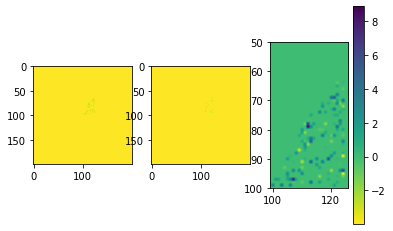

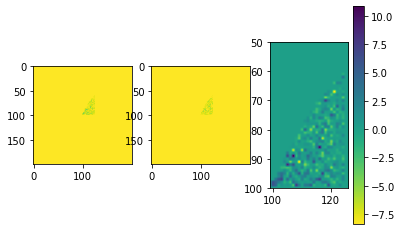

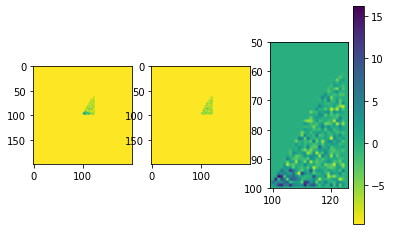

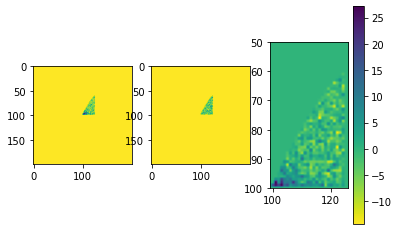

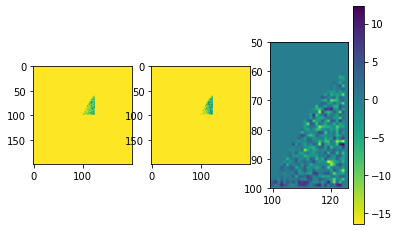

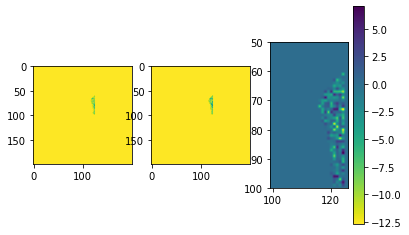

In [96]:
plt.figure()
plt.subplot(131)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,0],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(132)
plt.imshow(misorientation_axis_matrix3D_list[1][:,:,0],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(133)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,0]-misorientation_axis_matrix3D_list[1][:,:,0],cmap = 'viridis_r')
plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2+1])
plt.ylim([axis_num_bin/2,axis_num_bin/2-axis_num_bin/4])
plt.colorbar()
# plt.colorbar()
plt.figure()
plt.subplot(131)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,1],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(132)
plt.imshow(misorientation_axis_matrix3D_list[1][:,:,1],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(133)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,1]-misorientation_axis_matrix3D_list[1][:,:,1],cmap = 'viridis_r')
plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2+1])
plt.ylim([axis_num_bin/2,axis_num_bin/2-axis_num_bin/4])
plt.colorbar()
# plt.colorbar()
plt.figure()
plt.subplot(131)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,2],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(132)
plt.imshow(misorientation_axis_matrix3D_list[1][:,:,2],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(133)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,2]-misorientation_axis_matrix3D_list[1][:,:,2],cmap = 'viridis_r')
plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2+1])
plt.ylim([axis_num_bin/2,axis_num_bin/2-axis_num_bin/4])
plt.colorbar()
# plt.colorbar()
plt.figure()
plt.subplot(131)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,3],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(132)
plt.imshow(misorientation_axis_matrix3D_list[1][:,:,3],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(133)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,3]-misorientation_axis_matrix3D_list[1][:,:,3],cmap = 'viridis_r')
plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2+1])
plt.ylim([axis_num_bin/2,axis_num_bin/2-axis_num_bin/4])
plt.colorbar()
# plt.colorbar()
plt.figure()
plt.subplot(131)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,4],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(132)
plt.imshow(misorientation_axis_matrix3D_list[1][:,:,4],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(133)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,4]-misorientation_axis_matrix3D_list[1][:,:,4],cmap = 'viridis_r')
plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2+1])
plt.ylim([axis_num_bin/2,axis_num_bin/2-axis_num_bin/4])
plt.colorbar()
# plt.colorbar()
plt.figure()
plt.subplot(131)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,5],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(132)
plt.imshow(misorientation_axis_matrix3D_list[1][:,:,5],cmap = 'viridis_r',vmin=0,vmax=misorientation_axis_matrix3D.max())
plt.subplot(133)
plt.imshow(misorientation_axis_matrix3D_list[0][:,:,5]-misorientation_axis_matrix3D_list[1][:,:,5],cmap = 'viridis_r')
plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2+1])
plt.ylim([axis_num_bin/2,axis_num_bin/2-axis_num_bin/4])
plt.colorbar()
# plt.colorbar()

## Inclination calculation 

In [ ]:
    inclination_polar_angle_distribution_list = []
    inclination_azimuth_angle_distribution_list = []
    inclination_energy_distribution_list = []
    inclination_axis_matrix_list = []
    num_bin_inclination = 50
    num_bin_inclination_plot = int(90/90*num_bin_inclination)
    for i in range(len(input_npy_data)):
        microstructure = microstructure_list[i]
        # Aniso - ave
        data_file_name = f'/3D_normal_distribution_data/3D_{case_name}_normal_distribution_ave_fully5d_{compare_label[i]}_step{special_step_distribution[i]}.npz'
        if os.path.exists(current_path + data_file_name):
            inclination_npz_data = np.load(current_path + data_file_name)
            P = inclination_npz_data["P"]
            sites = inclination_npz_data["sites"]
        else:
            newplace = np.rot90(microstructure, 1, (0,1))
            P, sites, _ = inclination_processing.get_normal_vector_3d(newplace)
            # np.savez(current_path + data_file_name, P=P, sites=sites)

        inclination_polar_angle_distribution, inclination_azimuth_angle_distribution, inclination_axis_matrix, inclination_energy_distribution = get_inclination_angle_distribution_2D(P, sites, miso_dict, num_bin_inclination)
        inclination_polar_angle_distribution_list.append(inclination_polar_angle_distribution)
        inclination_azimuth_angle_distribution_list.append(inclination_azimuth_angle_distribution)
        inclination_energy_distribution_list.append(inclination_energy_distribution)
        inclination_axis_matrix_list.append(inclination_axis_matrix)
        print(f"> {compare_label[i]} done")


## Plot

The max anisotropy for 2400_20kMI in Inclination is 0.502644004175392


<Figure size 432x288 with 0 Axes>

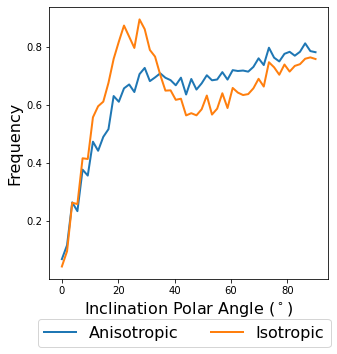

<Figure size 432x288 with 0 Axes>

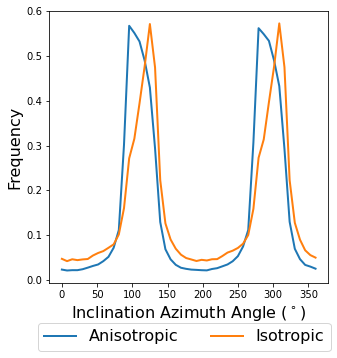

<Figure size 432x288 with 0 Axes>

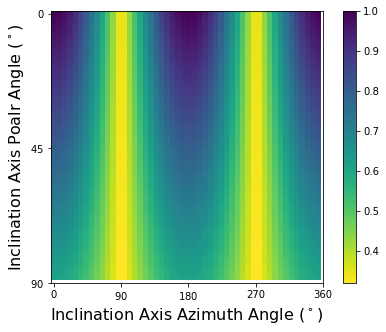

<Figure size 432x288 with 0 Axes>

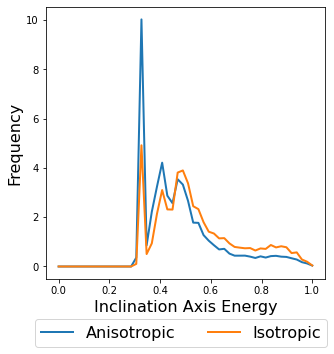

<Figure size 432x288 with 0 Axes>

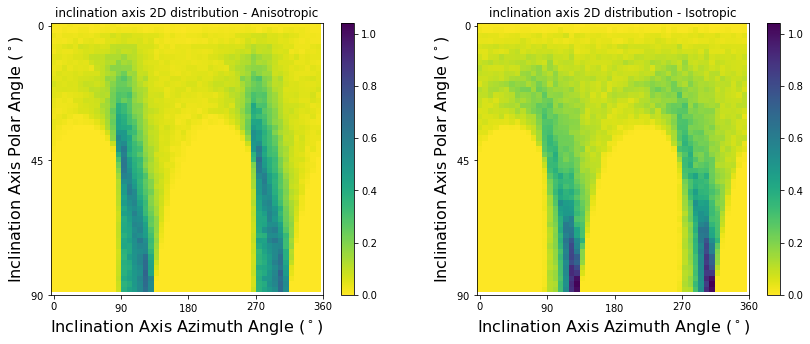

<Figure size 432x288 with 0 Axes>

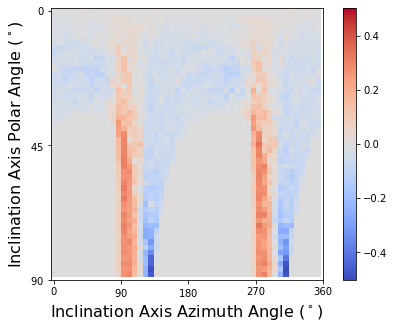

In [30]:
    # plot inclination angle distribution
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,90,num_bin_inclination)[:num_bin_inclination_plot], inclination_polar_angle_distribution_list[i][:num_bin_inclination_plot], label=compare_label[i], linewidth=2)
    plt.legend(loc=(-0.04,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Inclination Polar Angle ($^\circ$)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    # plt.savefig(current_path + f"/figures/{case_name}_inclination_polar_angle_distribution_2dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')


    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,360,num_bin_inclination)[:num_bin_inclination_plot], inclination_azimuth_angle_distribution_list[i][:num_bin_inclination_plot], label=compare_label[i], linewidth=2)
    plt.legend(loc=(-0.04,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Inclination Azimuth Angle ($^\circ$)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    # plt.savefig(current_path + f"/figures/{case_name}_inclination_azimuth_angle_distribution_2dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

    # inclination energy distribution
    i_axis_energy_function = np.zeros((num_bin_inclination, num_bin_inclination))
    for input_i in range(num_bin_inclination):
        for input_j in range(num_bin_inclination):
            i_axis_energy_function[input_i, input_j] = energy_function_i_axis(input_i/num_bin_inclination*np.pi/2, input_j/num_bin_inclination*2*np.pi)
    plt.figure()
    fig = plt.figure(figsize=(7, 5))
    plt.imshow(i_axis_energy_function,cmap='viridis_r')
    plt.xlabel(r"Inclination Axis Azimuth Angle ($^\circ$)", fontsize=16)
    plt.ylabel(r"Inclination Axis Poalr Angle ($^\circ$)", fontsize=16)
    plt.xticks(np.linspace(0,num_bin_inclination,5), ['0',r'$90$',r'$180$',r'270',r'360'])
    plt.yticks(np.linspace(0,num_bin_inclination,3), ['0',r'$45$',r'$90$'])
    plt.colorbar()
    # plt.title("inclination axis energy function")
    plt.savefig(current_path + f"/figures/{case_name}_inclination_energy_2dofs.png", dpi=400,bbox_inches='tight')

    # inclination energy distribution
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,1,num_bin_inclination)[:num_bin_inclination_plot], inclination_energy_distribution_list[i][:num_bin_inclination_plot], label=compare_label[i], linewidth=2)
    plt.legend(loc=(-0.04,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Inclination Axis Energy", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    # plt.savefig(current_path + f"/figures/{case_name}_inclination_axis_energy_distribution_2dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

    # plot matrix figure for inclination axis distribution
    plt.figure()
    fig = plt.figure(figsize=(14, 5))
    for i in range(len(input_npy_data)):
        plt.subplot(1,2,int(i+1))
        plt.imshow(inclination_axis_matrix_list[i],cmap='viridis_r',vmin=0,vmax=np.max(inclination_axis_matrix_list))
        plt.title(compare_label[i])
        plt.xlabel(r"Inclination Axis Azimuth Angle ($^\circ$)", fontsize=16)
        plt.ylabel(r"Inclination Axis Polar Angle ($^\circ$)", fontsize=16)
        plt.xticks(np.linspace(0,num_bin_inclination,5), ['0',r'$90$',r'$180$',r'270',r'360'])
        plt.yticks(np.linspace(0,num_bin_inclination,3), ['0',r'$45$',r'$90$'])
        plt.colorbar()
        plt.title(f"inclination axis 2D distribution - {compare_label[i]}")
    # plt.savefig(current_path + f"/figures/{case_name}_inclination_axis_2D_distribution_2dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')
    # plot matrix difference for misorientation axis distribution
    max_anisotropy = np.max(abs(inclination_axis_matrix_list[0]-inclination_axis_matrix_list[1]))
    print(f"The max anisotropy for {case_name} in Inclination is {max_anisotropy}")
    plt.figure()
    fig = plt.figure(figsize=(7, 5))
    plt.imshow(inclination_axis_matrix_list[0]-inclination_axis_matrix_list[1],cmap='coolwarm',vmin=-np.max(abs(inclination_axis_matrix_list[0]-inclination_axis_matrix_list[1])),vmax=np.max(abs(inclination_axis_matrix_list[0]-inclination_axis_matrix_list[1])))
    plt.xlabel(r"Inclination Axis Azimuth Angle ($^\circ$)", fontsize=16)
    plt.ylabel(r"Inclination Axis Polar Angle ($^\circ$)", fontsize=16)
    plt.xticks(np.linspace(0,num_bin_inclination,5), ['0',r'$90$',r'$180$',r'270',r'360'])
    plt.yticks(np.linspace(0,num_bin_inclination,3), ['0',r'$45$',r'$90$'])
    # plt.title(f"inclination axis 2D distribution difference (aniso-iso)")
    plt.colorbar()
    plt.savefig(current_path + f"/figures/{case_name}_inclination_axis_2D_distribution_difference_2dofs_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')


Text(0.5, 1.0, 'misoreintation axis 2D energy function value for Aniso')

<Figure size 432x288 with 0 Axes>

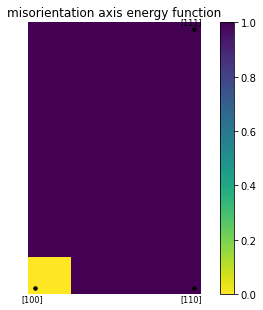

<Figure size 432x288 with 0 Axes>

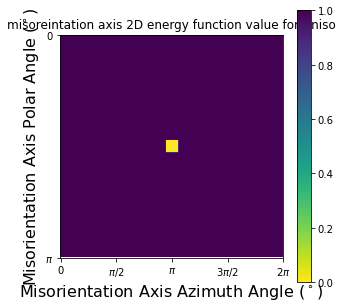

In [121]:
def energy_function_m_axis_new_test(m_polar_angle, m_azimuth_angle):
    # ss = (abs(np.cos(m_azimuth_angle/2))**0.2 + abs(np.cos(m_polar_angle))**0.2)
    if abs(m_azimuth_angle - np.pi) < np.pi/18 and abs(m_polar_angle - np.pi/2) < np.pi/36: ss = 0
    else: ss = 1
    if ss > 1: return 1
    else: return ss
    # return (abs(np.cos(m_azimuth_angle/2))**0.5 + abs(np.cos(m_polar_angle))**0.5)
    # return abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))

# With misorientation angle of 10 degree
axis_num_bin=200
# plot energy function
# 100, 110, 111
axis_100 = [axis_num_bin/2, int(0.5*np.pi//(np.pi/axis_num_bin))]
axis_110 = [axis_num_bin/2+int(0.25*np.pi//(2*np.pi/axis_num_bin)), int(0.5*np.pi//(np.pi/axis_num_bin))]
axis_111 = [axis_num_bin/2+int(0.25*np.pi//(2*np.pi/axis_num_bin)),int(0.9553//(np.pi/axis_num_bin))]
m_axis_energy_function = np.zeros((axis_num_bin, axis_num_bin))
for input_i in range(axis_num_bin):
    for input_j in range(axis_num_bin):
        m_axis_energy_function[input_i, input_j] = energy_function_m_axis_new_test(input_i/axis_num_bin*np.pi, input_j/axis_num_bin*2*np.pi)
plt.figure()
fig = plt.figure(figsize=(7, 5))
min_tri = np.min(m_axis_energy_function[int(axis_num_bin/2):int(axis_num_bin/8+axis_num_bin/2), int(0.9553//(np.pi/axis_num_bin)):int(axis_num_bin/2)])
max_tri = np.max(m_axis_energy_function[int(axis_num_bin/2):int(axis_num_bin/8+axis_num_bin/2), int(0.9553//(np.pi/axis_num_bin)):int(axis_num_bin/2)])
plt.imshow(m_axis_energy_function,cmap='viridis_r',vmin=min_tri,vmax = max_tri)
plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
plt.ylabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
plt.yticks(np.linspace(0,axis_num_bin,3), ['0',r'$\pi/2$',r'$\pi$'])
plt.xlim([axis_num_bin/2-1,axis_num_bin/8+axis_num_bin/2])
plt.ylim([axis_num_bin/2,int(0.9553//(np.pi/axis_num_bin)-1)])
plt.colorbar()
plt.title("misorientation axis energy function")
plt.scatter(axis_100[0],axis_100[1],c='k',s=12)
plt.text(axis_100[0]-2, axis_100[1]+2, "[100]", fontsize=8)
plt.scatter(axis_110[0],axis_110[1],c='k',s=12)
plt.text(axis_110[0]-2, axis_110[1]+2, "[110]", fontsize=8)
plt.scatter(axis_111[0],axis_111[1],c='k',s=12)
plt.text(axis_111[0]-2, axis_111[1]-0.7, "[111]", fontsize=8)
plt.axis("off")

# plot energy function
m_axis_energy_function_test = np.zeros((axis_num_bin, axis_num_bin))
for input_i in range(axis_num_bin):
    for input_j in range(axis_num_bin):
        m_axis_energy_function_test[input_i, input_j] = energy_function_m_axis_new_test(input_i/axis_num_bin*np.pi, input_j/axis_num_bin*2*np.pi)
plt.figure()
fig = plt.figure(figsize=(5, 5))
plt.imshow(m_axis_energy_function_test,cmap='viridis_r')
plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
plt.ylabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
plt.yticks(np.linspace(0,axis_num_bin,2), ['0',r'$\pi$'])
plt.colorbar()
plt.title("misoreintation axis 2D energy function value for Aniso")


<Figure size 432x288 with 0 Axes>

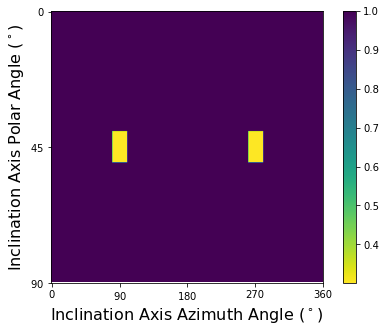

In [9]:
def energy_function_i_axis_well(i_polar_angle, i_azimuth_angle):
    if (abs(i_azimuth_angle - np.pi/2) < np.pi/18 or abs(i_azimuth_angle - 3*np.pi/2) < np.pi/18) and abs(i_polar_angle - np.pi/4) < np.pi/36: ss = 0.301
    else: ss = 1
    if ss > 1: return 1
    else: return ss
    # return (abs(np.cos(m_azimuth_angle/2))**0.5 + abs(np.cos(m_polar_angle))**0.5)
    # return abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))

# plot energy function
axis_num_bin=200
i_axis_energy_function = np.zeros((axis_num_bin, axis_num_bin))
for input_i in range(axis_num_bin):
    for input_j in range(axis_num_bin):
        i_axis_energy_function[input_i, input_j] = energy_function_i_axis_well(input_i/axis_num_bin*np.pi/2, input_j/axis_num_bin*2*np.pi)
plt.figure()
fig = plt.figure(figsize=(7, 5))
plt.imshow(i_axis_energy_function,cmap='viridis_r')
plt.xlabel(r"Inclination Axis Azimuth Angle ($^\circ$)", fontsize=16)
plt.ylabel(r"Inclination Axis Polar Angle ($^\circ$)", fontsize=16)
plt.xticks(np.linspace(0,axis_num_bin,5), ['0',r'$90$',r'$180$',r'270',r'360'])
plt.yticks(np.linspace(0,axis_num_bin,3), ['0',r'$45$',r'$90$'])
plt.colorbar()
# plt.title("inclination axis 2D energy function value for Aniso")
plt.savefig(current_path + f"/figures/2D_20k_I_well_inclination_azimuth_angle_distribution.png", dpi=400,bbox_inches='tight')


Text(0, 0.5, 'Anisotropy Level')

<Figure size 432x288 with 0 Axes>

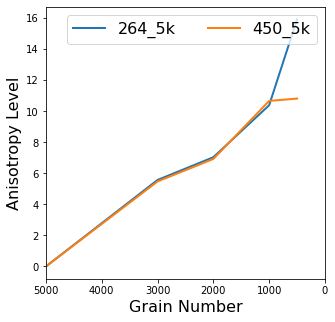

<Figure size 432x288 with 0 Axes>

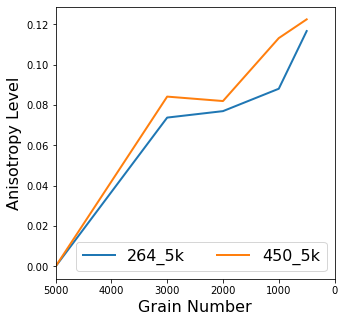

In [120]:

# PLot anisotropy level on misorientation and inclination
num_grains_array = np.array([5000, 3000, 2000,1000,500])
aniso_miso_264_5k = np.array([0.0, 5.574, 7.041, 10.391, 15.927])
aniso_inc_264_5k = np.array([0.0, 0.0738, 0.0770, 0.0881, 0.1167])
aniso_miso_450_5k = np.array([0.0, 5.479, 6.928, 10.670, 10.819])
aniso_inc_450_5k = np.array([0.0, 0.0842, 0.0820, 0.1132, 0.1225])



# Miso
plt.figure()
fig = plt.figure(figsize=(5, 5))
plt.plot(num_grains_array, aniso_miso_264_5k, label="264_5k", linewidth=2)
plt.plot(num_grains_array, aniso_miso_450_5k, label="450_5k", linewidth=2)
plt.legend(fontsize=16, ncol=2)
plt.xlim([5000,0])
plt.xlabel(r"Grain Number", fontsize=16)
plt.ylabel("Anisotropy Level", fontsize=16)

# Inc
plt.figure()
fig = plt.figure(figsize=(5, 5))
plt.plot(num_grains_array, aniso_inc_264_5k, label="264_5k", linewidth=2)
plt.plot(num_grains_array, aniso_inc_450_5k, label="450_5k", linewidth=2)
plt.legend(fontsize=16, ncol=2)
plt.xlim([5000,0])
plt.xlabel(r"Grain Number", fontsize=16)
plt.ylabel("Anisotropy Level", fontsize=16)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55])